# Introduction to Tensorflow


In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'1.15.0'

# PART 1. Logistic Regression

## (a) Calculate log-likelihood function in the above problem using R

```R
library(tidyverse)

mydata <- read.csv("https://stats.idre.ucla.edu/stat/data/binary.csv")
head(mydata) # admit (y) : 0/1, gre, gpa, rank : 설명변수

mymodel <- glm(admit ~ gre + gpa + rank, data = mydata, family = "binomial")
summary(mymodel)

## 1: 1 0 380 3.61 3
z=-3.449548 + 0.002294*380 +0.777014 *3.61 -0.560031 *3
p=1/(1+exp(-z))
p # 확률 0.1895556

## 3: 1 800 4.00 1
z3=-3.449548 + 0.002294*800 +0.777014 *4.00 -0.560031 *1
p3=1/(1+exp(-z3))
p3 # 확률 0.7178207 

predict(mymodel, type="response") # 각각의 데이터에 대한 predict 값 

# log likelihood
pred <- cbind(mydata, predict(mymodel, type="response"))
pred <- as_tibble(pred) %>% rename(y=admit, ypred = "predict(mymodel, type = \"response\")", gre=gre, gpa=gpa, rank=rank)
pred <- pred %>% mutate(loglike = -(y*log(ypred)+(1-y)*log(1-ypred)))
sum(pred$loglike)/400

```

![R1](https://user-images.githubusercontent.com/43749571/95837094-294d4380-0d7b-11eb-82a5-8b0566f74e15.JPG)

![R2](https://user-images.githubusercontent.com/43749571/95837097-29e5da00-0d7b-11eb-89d7-a42ab1bac298.JPG)

![R3](https://user-images.githubusercontent.com/43749571/95837099-2b170700-0d7b-11eb-86da-3a06306effaa.JPG)

## (b) Calculate log-likelihood function in the above problem using tensorflow.

### Data 불러오기 

In [4]:
import pandas as pd 
import numpy as np

In [ ]:
mydata = pd.read_csv("https://stats.idre.ucla.edu/stat/data/binary.csv")
mydata.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [ ]:
mydata = mydata.to_numpy() # numpy 형태로 바꿔준다 

In [ ]:
mydata_exp = mydata[:, 1:] # 설명변수 (x)
mydata_rep = mydata[:, 0] # 반응변수 (y)

In [ ]:
print(mydata_exp.shape, mydata_rep.shape) 

(400, 3) (400,)


In [ ]:
m, n = mydata_exp.shape # (400, 3)
mydata_exp_plus_bias = np.c_[np.ones((m, 1)), mydata_exp] # (400, 4)

In [ ]:
scaled_mydata_exp_plus_bias = mydata_exp_plus_bias / mydata_exp_plus_bias.max(axis=0) # 0과 1 사이의 숫자로 scaling 
scaled_mydata_exp_plus_bias.shape

(400, 4)

### logistic regression with tensorflow 

In [ ]:
X = tf.constant(scaled_mydata_exp_plus_bias, dtype=tf.float32, name="X") # (400, 4)
y = tf.constant(mydata_rep.reshape(-1, 1), dtype=tf.float32, name="y") # (400, 1)
XT = tf.transpose(X)

In [ ]:
beta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

In [ ]:
with tf.Session() as sess:
    beta_value = beta.eval()
    
print(beta_value) # beta0, beta1, beta2, beta3 (상수항, gre, gpa, rank)

[[-0.18242253]
 [ 0.3539362 ]
 [ 0.604179  ]
 [-0.43800795]]


In [ ]:
z = np.matmul(scaled_mydata_exp_plus_bias, beta_value) # X*beta
predict = tf.sigmoid(z)  # y = 1 / (1 + exp(-z)) : 확률값으로 나오게 됨 

In [ ]:
with tf.Session() as sess:
    y_pred = predict.eval()

In [ ]:
myy = mydata_rep.reshape(-1, 1) # y 

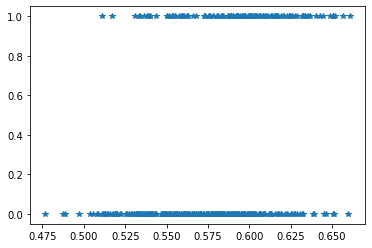

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_pred, myy, "*") # predict 값들이 어떤 분포를 보이고 있는지, 이 때의 실제 y값과의 관계는 어떠한지에 대한 비교 

In [ ]:
# 비교해 보아야 할 beta 값 
b_beta_value = np.multiply(beta_value, mydata_exp_plus_bias.max(axis=0).reshape(-1,1))
b_beta_value

array([[-1.82422534e-01],
       [ 2.83148956e+02],
       [ 2.41671610e+00],
       [-1.75203180e+00]])

In [ ]:
# log likelihood 
b_loglik = -np.mean(myy*np.log(y_pred) + (1-myy)*np.log(1-y_pred))
b_loglik

0.7453664863257206

## (c) Calculate log-likelihood function in the above problem using tensorflow and mini batch learning

### Gradient Descent 

In [ ]:
# 준비 
n_epochs = 30000
learning_rate = 0.005

# 선언만 계속 해줌 : X, y, beta, mse 
X = tf.constant(scaled_mydata_exp_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(mydata_rep.reshape(-1, 1), dtype=tf.float32, name="y")

beta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name="beta") # 왜 Variable? beta 바꿔가면서 cost function optimize 할 것이기 때문에 
y_pred = tf.sigmoid(tf.matmul(X, beta, name="predictions")) # 확률값 
cost = -tf.reduce_mean(y*tf.log(y_pred) + (1-y)*tf.log(1-y_pred)) # binary cross entropy 

# beta_hat 는 "cost function을 최소화" 시키는 beta

# optimum value를 찾는 계산기 만들기 = cost function를 최소화 시켜줘 !! 
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
training_op = optimizer.minimize(cost) # beta <- beta -learning_rate*기울기 : 1 step 

In [ ]:
init = tf.global_variables_initializer() # beta (variable)
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 1000 == 0:
            print("Epoch", epoch, "Cost =", cost.eval())
        sess.run(training_op) # 1 step을 가시오. 한 바퀴 (1000번) 끝나면 나올 것 
    best_beta = beta.eval() # beta값 계속 변하게 됨 
print(best_beta) 

Epoch 0 Cost = 0.68111175
Epoch 1000 Cost = 0.6263726
Epoch 2000 Cost = 0.61900747
Epoch 3000 Cost = 0.6130547
Epoch 4000 Cost = 0.60822463
Epoch 5000 Cost = 0.6042875
Epoch 6000 Cost = 0.60106146
Epoch 7000 Cost = 0.5984029
Epoch 8000 Cost = 0.5961983
Epoch 9000 Cost = 0.5943582
Epoch 10000 Cost = 0.59281164
Epoch 11000 Cost = 0.59150255
Epoch 12000 Cost = 0.5903859
Epoch 13000 Cost = 0.5894263
Epoch 14000 Cost = 0.58859503
Epoch 15000 Cost = 0.5878693
Epoch 16000 Cost = 0.5872305
Epoch 17000 Cost = 0.5866638
Epoch 18000 Cost = 0.58615714
Epoch 19000 Cost = 0.5857007
Epoch 20000 Cost = 0.5852865
Epoch 21000 Cost = 0.584908
Epoch 22000 Cost = 0.5845598
Epoch 23000 Cost = 0.5842375
Epoch 24000 Cost = 0.58393764
Epoch 25000 Cost = 0.583657
Epoch 26000 Cost = 0.58339316
Epoch 27000 Cost = 0.5831441
Epoch 28000 Cost = 0.582908
Epoch 29000 Cost = 0.5826835
[[-0.66179717]
 [ 1.3787856 ]
 [ 0.34281203]
 [-2.3480084 ]]


In [ ]:
# 비교해 보아야 할 beta 값 
c1_beta_value = np.multiply(best_beta, mydata_exp_plus_bias.max(axis=0).reshape(-1,1))
c1_beta_value

array([[-6.61797166e-01],
       [ 1.10302849e+03],
       [ 1.37124813e+00],
       [-9.39203358e+00]])

### Mini Batch Learning 

In [ ]:
# placeholder : 상수처럼 쓰이는데, 항상 같은 데이터 쓰지 않고, for문 돌릴 때 마다 다른 데이터가 들어간다 
X = tf.placeholder(tf.float32, shape=[None,n+1]) # 이전에는 constant, batch learning 때문에 None이라고 지정해 줌 
y = tf.placeholder(tf.float32, shape=[None,1])   

beta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name="beta")
y_pred = tf.sigmoid(tf.matmul(X, beta, name="predictions"))
cost = -tf.reduce_mean(y*tf.log(y_pred) + (1-y)*tf.log(1-y_pred)) # binary cross entropy 

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(cost)



batch_size = 20  # beta1 에서 beta2 로 갈 때 20개의 데이터만 쓴다 
n_batches = m//batch_size  # 한 바퀴 다 돌아간다 


init = tf.global_variables_initializer()
sess = tf.Session()

In [ ]:
XX = scaled_mydata_exp_plus_bias # X data
YY = mydata_rep.reshape(-1, 1)   # y data

In [ ]:
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(30000): # 데이터 30000번 사용, 20개씩 사용해서 beta 0 에서 beta 1000, 이걸 처음부터 가는걸 30000번 
        
        for i in range(n_batches): # 여기서 1000바퀴 
            start = i * batch_size # 0, 20, ...
            end = start+batch_size # 20, 40, ... 
            
            sess.run(training_op, feed_dict={X:XX[start:end,:], # optimization에 쓰일 x에 20개씩, y에 20개씩 넣어준다 
                                             y:YY[start:end,:]
                                            }) # placeholder에 사전형식으로 넣어줌 

            best_beta2 = beta.eval() # beta update 

        ttt = sess.run(cost, feed_dict={X:XX, y: YY}) # 한 바퀴 돌 때 마다 cost 얼만큼 되는지 ... 
        
        if epoch % 1000 == 0 :
            print("Epoch", epoch, "Cost =", ttt) # 출력 

print(best_beta2)

Epoch 0 Cost = 0.7846402
Epoch 1000 Cost = 0.5897516
Epoch 2000 Cost = 0.5844848
Epoch 3000 Cost = 0.5820527
Epoch 4000 Cost = 0.58042926
Epoch 5000 Cost = 0.579215
Epoch 6000 Cost = 0.57827306
Epoch 7000 Cost = 0.57753
Epoch 8000 Cost = 0.57693726
Epoch 9000 Cost = 0.5764604
Epoch 10000 Cost = 0.57607436
Epoch 11000 Cost = 0.5757603
Epoch 12000 Cost = 0.5755037
Epoch 13000 Cost = 0.5752934
Epoch 14000 Cost = 0.57512087
Epoch 15000 Cost = 0.57497895
Epoch 16000 Cost = 0.57486194
Epoch 17000 Cost = 0.5747654
Epoch 18000 Cost = 0.57468575
Epoch 19000 Cost = 0.57461977
Epoch 20000 Cost = 0.57456535
Epoch 21000 Cost = 0.5745203
Epoch 22000 Cost = 0.574483
Epoch 23000 Cost = 0.57445204
Epoch 24000 Cost = 0.5744265
Epoch 25000 Cost = 0.57440525
Epoch 26000 Cost = 0.5743877
Epoch 27000 Cost = 0.5743731
Epoch 28000 Cost = 0.5743611
Epoch 29000 Cost = 0.5743511
[[-3.263607 ]
 [ 1.8564334]
 [ 2.8801005]
 [-2.2476957]]


In [ ]:
# 비교해 보아야 할 beta 값 
c2_beta_value = np.multiply(best_beta2, mydata_exp_plus_bias.max(axis=0).reshape(-1,1))
c2_beta_value

array([[  -3.26360703],
       [1485.14671326],
       [  11.52040195],
       [  -8.99078274]])

## (d) beta0, beta1, beta2, beta3 값들을 위의 3가지 방법에 대해서 구하고 비교하세요.

In [ ]:
# R: [[-3.449548, 0.002294, 0.777014, -0.560031]]

In [ ]:
b_beta_value # X'X를 통해 beta 값 구했을 때 

array([[-1.82422534e-01],
       [ 2.83148956e+02],
       [ 2.41671610e+00],
       [-1.75203180e+00]])

In [ ]:
c1_beta_value # gradient descent 

array([[-6.61797166e-01],
       [ 1.10302849e+03],
       [ 1.37124813e+00],
       [-9.39203358e+00]])

In [ ]:
c2_beta_value # gradient descent + mini batch 

array([[  -3.26360703],
       [1485.14671326],
       [  11.52040195],
       [  -8.99078274]])

## (e) log-likelihood function 을 구하고 위의 3가지 방법에 대해서 구하고 비교하세요.

#### cost = -mean(y x tf.log(y_pred) + (1-y) x tf.log(1-y_pred))
>* R : 0.5743022
* only Gradient Descent : 0.5797468
* GD + Mini Batch : 0.57432866


* beta 값은 다 다르게 나오지만, 3가지 방법 모두 cost function의 최종값은 0.57 정도에서 끝난다! 

# PART 2. 긍정/부정리뷰 예측 모델 설계 (IMDB data) 

#### Neural Network 구조 
>* 0층의 입력데이터는 x_train
* 1층은 hidden unit 의 갯수가 16, activation function = "relu"
* 2층은 hidden unit 의 갯수가 16, activation function = "relu"
* 3층은 출력층으로 p_hat 하나를 출력하고, , activation function = "sigmoid"

>* model fitting시 batch size = 512로 하고, 각 데이터가 평균 4번씩 (epoch=4) 사용 될수 있도록 하세요. 필요시 epoch size를 늘릴 수 있습니다.


## (a) Data preparation 

In [5]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000) # 자주 나타난 10000개의 word만 keep 

Using TensorFlow backend.


17465344/17464789 [==============================] - 0s 0us/step


In [6]:
print(train_data[0], train_labels[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32] 1


In [7]:
# Encoding the integer sequences into a binary matrix
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) # (len(sequence), dimension) shape의 zero vector 만들기 

    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. # 해당 순서의 단어가 존재하면, 1로 바꿔줌 

    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [8]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [9]:
print(x_train[0], y_train[0])

[0. 1. 1. ... 0. 0. 0.] 1.0


In [10]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(25000, 10000) (25000, 10000) (25000,) (25000,)


## (b) 모델에서 사용된 parameter의 차원 계산

![dim](https://user-images.githubusercontent.com/43749571/95837081-25212600-0d7b-11eb-95a1-992b8998dd46.jpg)

## (c) Modeling 
* 신경망 모델을 tensorflow를 사용하여 모델링하고, binary_cross entropy 손실함수 (logistic regression에서 log-likelihood function에 minus sign을 붙인 것) 이를 적절한 옵티마이져를 사용하여 model fitting을 실시하세요. 이 과정에 대한 간략한 코멘트를 추가해 주세요.

In [11]:
y_train_onehot = tf.one_hot(y_train, 2)
y_train_onehot = tf.reshape(y_train_onehot, [-1, 2]) # placeholder에 맞게끔 shape 조정 

In [12]:
y_test_onehot = tf.one_hot(y_test, 2)
y_test_onehot = tf.reshape(y_test_onehot, [-1, 2])

In [13]:
with tf.Session() as sess:
    y_train_onehot = y_train_onehot.eval()
    y_test_onehot = y_test_onehot.eval()

In [14]:
y_train_onehot

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [15]:
y_test_onehot

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [16]:
print(y_train_onehot.shape, y_test_onehot.shape)

(25000, 2) (25000, 2)


In [26]:
# define the constant 

learning_rate = 0.001
num_epochs = 150  # 100 repetition for the whole data
batch_size = 512 # num of batch per one gradient descent
input_size = 10000
hidden1_size = 16
hidden2_size = 16 
output_size = 2

In [27]:
# define placeholder 

X=tf.placeholder(tf.float32, shape=[None, 10000])
y=tf.placeholder(tf.float32, shape=[None, 2])

In [28]:
# Neural Net 
W1 = tf.Variable(tf.random_normal(shape=[input_size, hidden1_size]))
b1 = tf.Variable(tf.random_normal(shape=[hidden1_size]) )
a1 = tf.nn.relu(tf.matmul(X, W1)+b1)

W2 = tf.Variable(tf.random_normal(shape=[hidden1_size, hidden2_size]))
b2 = tf.Variable(tf.random_normal(shape=[hidden2_size]) )
a2 = tf.nn.relu(tf.matmul(a1, W2)+b2)

W3 = tf.Variable(tf.random_normal(shape=[hidden2_size, output_size]))
b3 = tf.Variable(tf.random_normal(shape=[output_size]) )
z3 = tf.matmul(a2, W3)+b3


# return z3
logits = z3
y_pred = tf.nn.softmax(logits)


# loss 
# loss = tf.reduce_mean(-tf.reduce_sum(y*tf.log(y_pred), axis=1))
loss = tf.nn.softmax_cross_entropy_with_logits(logits = y_pred, labels = y)


# training 
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)


# batch 
n_batches = x_train.shape[0]//batch_size 

In [29]:
init = tf.global_variables_initializer()
sess = tf.Session()

## (d) train data의 정확도 / (e) test data의 정확도

In [30]:
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(num_epochs+1):  # 100+1 epoch 
        
        for i in range(n_batches):  
            start = i * batch_size 
            end = start+batch_size 
            
            sess.run(train_step, feed_dict={X:x_train[start:end,:], y:y_train_onehot[start:end,:]}) 


        correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1)) # 확률값 높은 곳으로 예측 
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))            

        if epoch % 10 == 0 : 
            print("epoch : {}, accuracy : {}".format(epoch, sess.run(accuracy, feed_dict={X:x_train, y:y_train_onehot})))



    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1)) # 확률값 높은 곳으로 예측 
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))  

    print("===========================================")
    print("Train accuracy : {}".format(sess.run(accuracy, feed_dict={X:x_train, y:y_train_onehot})))
    print("Test accuracy : {}".format(sess.run(accuracy, feed_dict={X:x_test, y:y_test_onehot})))

epoch : 0, accuracy : 0.505079984664917
epoch : 10, accuracy : 0.5879600048065186
epoch : 20, accuracy : 0.6444000005722046
epoch : 30, accuracy : 0.669439971446991
epoch : 40, accuracy : 0.7075600028038025
epoch : 50, accuracy : 0.7265999913215637
epoch : 60, accuracy : 0.7442799806594849
epoch : 70, accuracy : 0.7524799704551697
epoch : 80, accuracy : 0.7640399932861328
epoch : 90, accuracy : 0.7768399715423584
epoch : 100, accuracy : 0.7853999733924866
epoch : 110, accuracy : 0.7945600152015686
epoch : 120, accuracy : 0.8060799837112427
epoch : 130, accuracy : 0.8157600164413452
epoch : 140, accuracy : 0.821399986743927
epoch : 150, accuracy : 0.8271200060844421
Train accuracy : 0.8271200060844421
Test accuracy : 0.743120014667511
